# 02 – Employee Churn Analysis & Visuals

This notebook builds on `01_data_ingest.ipynb` and focuses on:

- Visualizing **monthly churn rates**
- Comparing **hires vs terminations** over time
- Exploring **tenure patterns** by current status

The goal is to show the kinds of insights a **People Analytics Specialist** might surface for HR leadership using the churn pipeline.


In [3]:
# Run the data ingest / preparation notebook to get:
# - master_employee_df
# - monthly_churn
%run ./01_data_ingest.ipynb

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Make sure the key objects exist
print("master_employee_df shape:", master_employee_df.shape)
print("monthly_churn shape:", monthly_churn.shape)

master_employee_df.head(), monthly_churn.head()


,employee_id,first_name,last_name,gender,birth_date,hire_date,termination_date,termination_reason,department_id,location,job_family,is_rehire
0,1001,Alice,Nguyen,F,1988-03-15,2019-01-10,NaN,NaN,HR,HQ,HR Generalist,False
1,1002,Brian,Lopez,M,1990-07-22,2020-05-01,2023-02-15,Voluntary - New Job,ENG,HQ,Data Engineer,False
2,1003,Chloe,Davis,F,1985-11-02,2018-09-17,NaN,NaN,FIN,HQ,Financial Analyst,False
3,1004,Derrick,Moore,M,1993-01-30,2021-03-05,2022-12-01,Involuntary - Performance,OPS,Plant A,Line Operator,False
4,1005,Elena,Rossi,F,1992-06-11,2021-11-20,NaN,NaN,OPS,Plant A,Line Operator,False


,employee_id,effective_date,status,status_reason
0,1001,2019-01-10,Active,Hire
1,1002,2020-05-01,Active,Hire
2,1002,2023-02-15,Terminated,Voluntary - New Job
3,1003,2018-09-17,Active,Hire
4,1004,2021-03-05,Active,Hire


,department_id,department_name
0,HR,Human Resources
1,ENG,Engineering
2,FIN,Finance
3,OPS,Operations
4,IT,Information Technology


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   employee_id         15 non-null     int64 
 1   first_name          15 non-null     object
 2   last_name           15 non-null     object
 3   gender              15 non-null     object
 4   birth_date          15 non-null     object
 5   hire_date           15 non-null     object
 6   termination_date    5 non-null      object
 7   termination_reason  5 non-null      object
 8   department_id       15 non-null     object
 9   location            15 non-null     object
 10  job_family          15 non-null     object
 11  is_rehire           15 non-null     bool  
dtypes: bool(1), int64(1), object(10)
memory usage: 1.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------        

(   employee_id first_name last_name gender  birth_date  hire_date  \
 0         1001      Alice    Nguyen      F  1988-03-15 2019-01-10   
 1         1002      Brian     Lopez      M  1990-07-22 2020-05-01   
 2         1003      Chloe     Davis      F  1985-11-02 2018-09-17   
 3         1004    Derrick     Moore      M  1993-01-30 2021-03-05   
 4         1005      Elena     Rossi      F  1992-06-11 2021-11-20   
 
   termination_date         termination_reason department_id location  \
 0              NaT                        NaN            HR       HQ   
 1       2023-02-15        Voluntary - New Job           ENG       HQ   
 2              NaT                        NaN           FIN       HQ   
 3       2022-12-01  Involuntary - Performance           OPS  Plant A   
 4              NaT                        NaN           OPS  Plant A   
 
           job_family  is_rehire  department_name current_status status_as_of  \
 0      HR Generalist      False  Human Resources        

## 1. Monthly Churn Rate Over Time

First, we'll look at how churn is changing over time in this simulated workforce.

- **Numerator:** number of terminations in the month  
- **Denominator:** month-end headcount  
- **Metric:** `churn_rate = terminations / headcount_end`


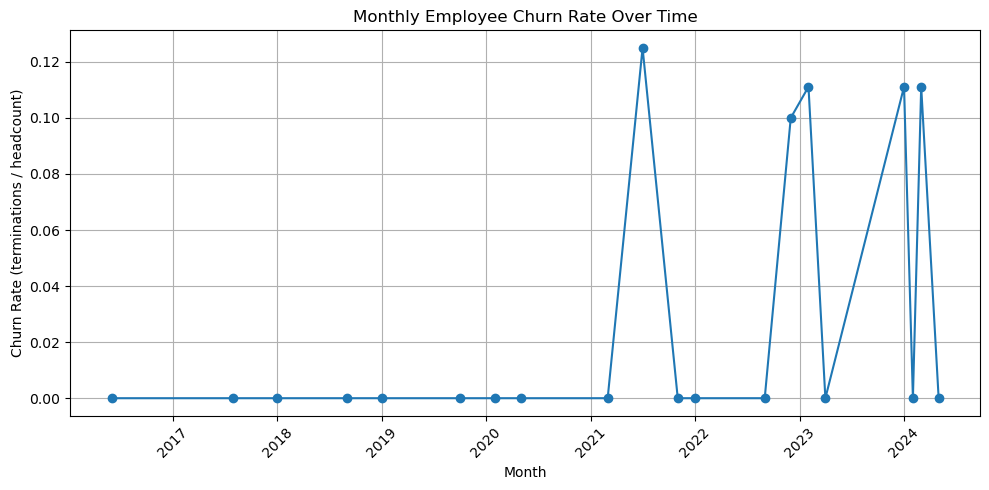

Average monthly churn rate: 2.79%
Max monthly churn rate: 12.50%
Min monthly churn rate: 0.00%


In [6]:
# Make a copy just to be safe
mc = monthly_churn.copy()

# Ensure it's sorted by month
mc = mc.sort_values("month")

plt.figure(figsize=(10, 5))
plt.plot(mc["month"], mc["churn_rate"], marker="o")
plt.title("Monthly Employee Churn Rate Over Time")
plt.xlabel("Month")
plt.ylabel("Churn Rate (terminations / headcount)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some summary stats
print("Average monthly churn rate: {:.2%}".format(mc["churn_rate"].mean()))
print("Max monthly churn rate: {:.2%}".format(mc["churn_rate"].max()))
print("Min monthly churn rate: {:.2%}".format(mc["churn_rate"].min()))


### Interpretation – Churn Trend

Here you can comment on what you see in the line chart, for example:

- Are there **spikes** in certain months?
- Is churn **increasing, decreasing, or stable** over time?
- Are there any **outlier months** where churn is unusually high?

In a real People Analytics setting, this could trigger questions like:

- “What happened in that high-churn month?”
- “Did we have a leadership change, policy shift, or major project ending?”


## 2. Hires vs Terminations by Month

Next, we'll compare **how many people we hired vs how many left** each month.

This helps answer questions like:

- Are we **net growing or shrinking**?
- Are there months where **terminations exceed hires**?


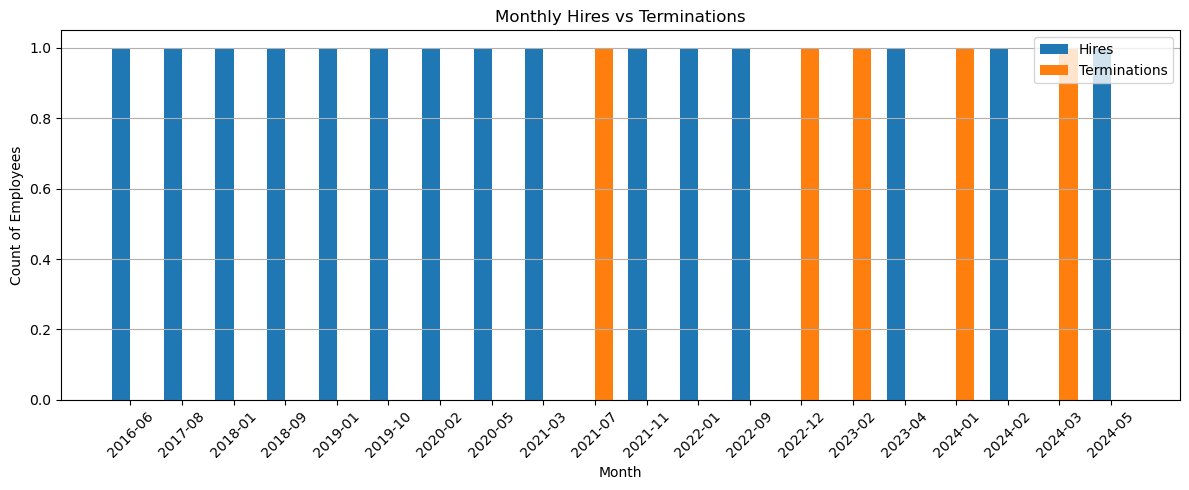

In [10]:
mc = monthly_churn.copy().sort_values("month")

# Fill NaN with 0 just in case
for col in ["hire", "termination"]:
    if col not in mc.columns:
        mc[col] = 0
mc[["hire", "termination"]] = mc[["hire", "termination"]].fillna(0)

x = np.arange(len(mc["month"]))  # positions for bars
width = 0.35                     # width of the bars

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, mc["hire"], width, label="Hires")
plt.bar(x + width/2, mc["termination"], width, label="Terminations")

plt.title("Monthly Hires vs Terminations")
plt.xlabel("Month")
plt.ylabel("Count of Employees")
plt.xticks(x, mc["month"].dt.strftime("%Y-%m"), rotation=45)
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()


### Interpretation – Hires and Terminations

Things to look for and comment on:

- Are there months with **many hires and few terminations** (growth)?
- Months with **few hires but many terminations** (possible risk)?
- Do hires and terminations track each other, or are they out of sync?




## 3. Tenure Patterns by Current Status

Now we’ll explore **tenure** using `master_employee_df`.

Questions we can answer:

- How long do employees who have **left** tend to stay?
- How does their tenure compare to employees who are still **Active**?


current_status
Active        5.158658
Terminated    2.708282
Name: tenure_years, dtype: float64


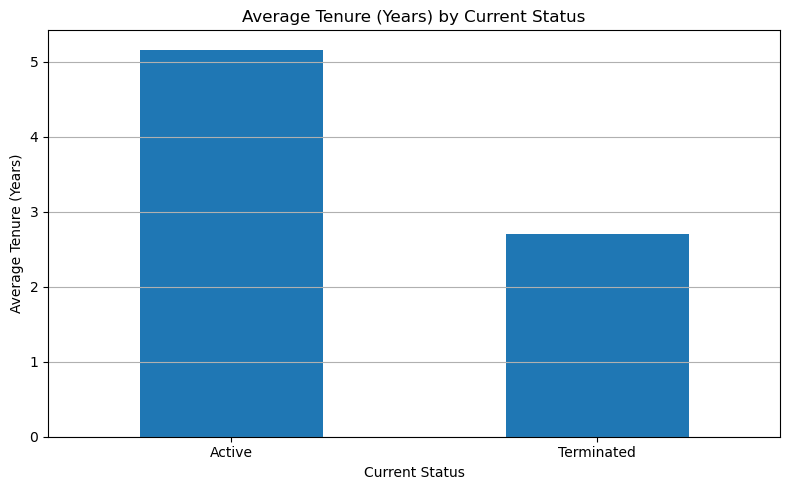

In [15]:
# Filter to reasonable tenure values (e.g., > 0 years)
df = master_employee_df.copy()
df = df[df["tenure_years"] >= 0]

avg_tenure = (
    df.groupby("current_status")["tenure_years"]
    .mean()
    .sort_values(ascending=False)
)

print(avg_tenure)

plt.figure(figsize=(8, 5))
avg_tenure.plot(kind="bar")
plt.title("Average Tenure (Years) by Current Status")
plt.ylabel("Average Tenure (Years)")
plt.xlabel("Current Status")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


### Interpretation – Tenure by Status

Typical patterns you might see:

- **Terminated** employees may have **shorter tenure** on average.
- **Active** employees might skew toward **longer tenure**.
- If the pattern is reversed, that’s also interesting to explain.




## 4. Optional – Tenure Distribution Histogram

We can also look at the overall distribution of tenure using a histogram:

- Are most employees clustered under 2 years?
- Do we have a long tail of very long-tenured employees?


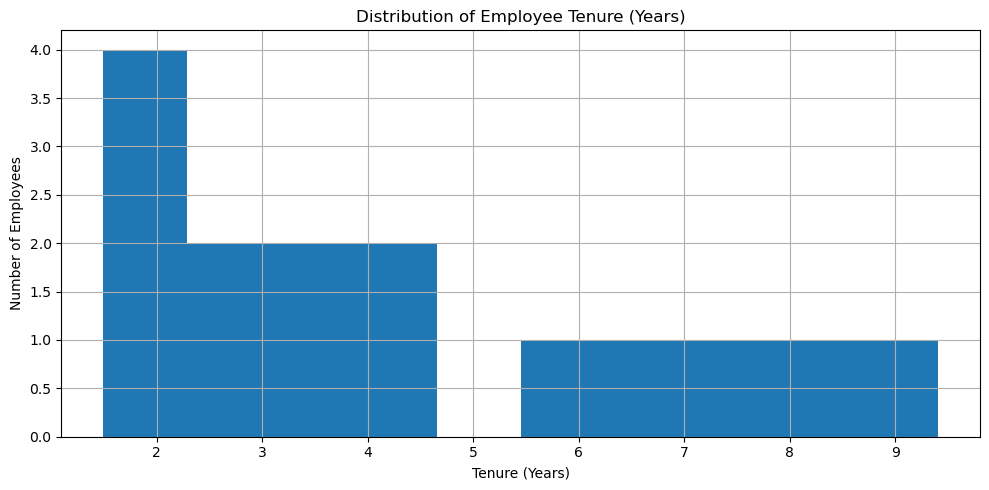

Tenure summary (years):
count    15.000000
mean      4.341866
std       2.600333
min       1.492129
25%       2.206708
50%       3.849418
75%       6.488706
max       9.407255
Name: tenure_years, dtype: float64


In [19]:
df = master_employee_df.copy()
df = df[df["tenure_years"] >= 0]

plt.figure(figsize=(10, 5))
plt.hist(df["tenure_years"], bins=10)
plt.title("Distribution of Employee Tenure (Years)")
plt.xlabel("Tenure (Years)")
plt.ylabel("Number of Employees")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Tenure summary (years):")
print(df["tenure_years"].describe())


## 5. Wrap-Up & Story for Stakeholders

From this notebook, we now have:

- A **churn trend line** with monthly churn rates.
- A **hires vs terminations** comparison by month.
- **Tenure insights** by current status and overall distribution.

In a real People Analytics context, these visuals could support:

- Quarterly HR reports
- Talent retention discussions with leadership
- Early warning signals when churn spikes


